In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, Input
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
input_path='/content/drive/MyDrive/CSE 559 DATASET'

In [4]:
input_data = []
output = []

for i in range(1, 301):
  # Path to your .mat file
  file_path = os.path.join(input_path, f'g{i}.mat')
  if os.path.exists(file_path):
    # Load the .mat file
    temp = loadmat(file_path)
    # Check if 'RPvsAoD' exists
    if 'RPvsAoD' in temp:
      input_data.append(np.reshape(temp['RPvsAoD'], [temp['RPvsAoD'].shape[0], temp['RPvsAoD'].shape[1], 1]))
      output.append(1)
    else:
      print(f"'RPvsAoD' not found in {file_path}")
  else:
    print(f"File not found: {file_path}")

for i in range(1, 168):
  # Path to your .mat file
  file_path = os.path.join(input_path, f'ng{i}.mat')
  if os.path.exists(file_path):
    # Load the .mat file
    temp = loadmat(file_path)
    # Check if 'RPvsAoD' exists
    if 'RPvsAoD' in temp:
      input_data.append(np.reshape(temp['RPvsAoD'], [temp['RPvsAoD'].shape[0], temp['RPvsAoD'].shape[1], 1]))
      output.append(0)
    else:
      print(f"'RPvsAoD' not found in {file_path}")
  else:
    print(f"File not found: {file_path}")

input_data = np.asarray(input_data, dtype = np.float32)
output = np.asarray(output, dtype = np.int8)
# Print the final shape of data
print("Shape of data:", input_data.shape)
print("Shape of output:", output.shape)

Shape of data: (467, 361, 181, 1)
Shape of output: (467,)


In [5]:
# Decide how many augmented samples you need
num_original = input_data.shape[0]
num_augmented = int((7/4) * num_original) # play with the number here
num_new = num_augmented - num_original

# Randomly select samples to augment
indices = np.random.choice(num_original, num_new, replace=True)

# Create augmented samples and inherit labels
augmented_samples = []
augmented_labels = []

for idx in indices:
    sample = input_data[idx]
    label = output[idx]

    # Add Gaussian noise to augment the sample
    noisy_sample = sample + np.random.normal(0, 10, sample.shape)

    # Clip the values to avoid extreme values (if required, e.g., range [0, 1])
    noisy_sample = np.clip(noisy_sample, np.min(sample), np.max(sample))

    augmented_samples.append(noisy_sample)
    augmented_labels.append(label)  # Inherit label

# Convert to NumPy arrays
augmented_samples = np.array(augmented_samples)  # Shape: (3, 361, 181)
augmented_labels = np.array(augmented_labels)   # Shape: (3,)

# Combine original and augmented data
X_final = np.concatenate([input_data, augmented_samples], axis=0)  # Shape: (8, 361, 181)
y_final = np.concatenate([output, augmented_labels], axis=0)   # Shape: (8,)

# Print shapes to verify
print("Final dataset shape:", X_final.shape)
print("Final labels shape:", y_final.shape)

Final dataset shape: (817, 361, 181, 1)
Final labels shape: (817,)


In [6]:
# One-hot encode labels
y_final = tf.keras.utils.to_categorical(y_final, num_classes=2)
print("Updated output shape:", y_final.shape)

Updated output shape: (817, 2)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 105s 946ms/step - accuracy: 0.5303 - loss: 1.1569 - val_accuracy: 0.6951 - val_loss: 77.5592
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.6083 - loss: 0.6745 - val_accuracy: 0.6951 - val_loss: 1.3454
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.6312 - loss: 0.6680 - val_accuracy: 0.6951 - val_loss: 1.4193
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.6409 - loss: 0.6622 - val_accuracy: 0.6951 - val_loss: 0.6219
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.5987 - loss: 0.6806 - val_accuracy: 0.6951 - val_loss: 0.6801
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.6095 - loss: 0.6758 - val_accuracy: 0.6951 - val_loss: 25.7622
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.6236 - loss: 0.6593 - val_accuracy: 0.6951 - val_loss: 105.6271
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6247 - loss: 0.6614 - val_

Model trained and saved successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7278 - loss: 1397.2899 
Validation Accuracy: 0.6951
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 896ms/step
F1 Score: 0.4101
Confusion Matrix:
 [[  0  50]
 [  0 114]]


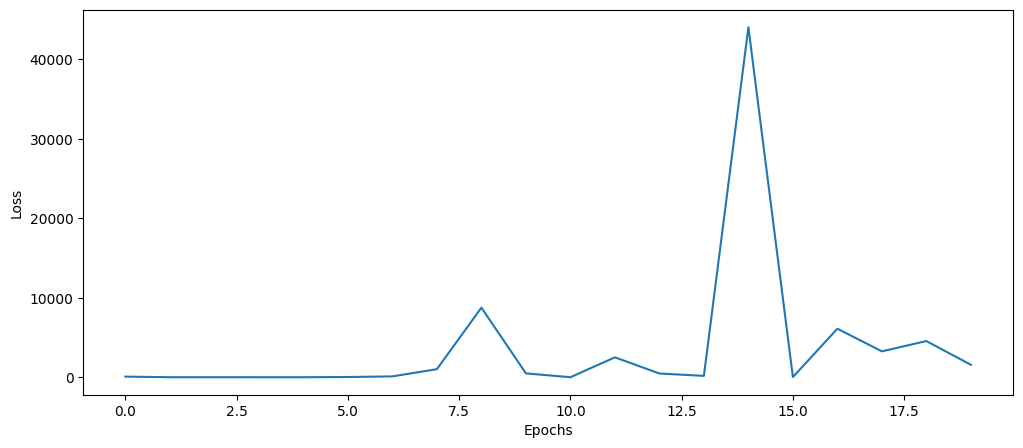

101329

In [8]:
# Split the data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Define ResNet model with modified input
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',  # Pretrained weights
    input_shape=(361, 181, 3)  # Input shape with 3 channels
)

# Modify the first Conv2D layer to accept single-channel input
input_layer = tf.keras.layers.Input(shape=(361, 181, 1))
x = tf.keras.layers.Conv2D(3, (7, 7), strides=(1, 1), padding='same', activation='relu')(input_layer)  # Convert 1-channel to 3
x = base_model(x, training=False)  # Pass through ResNet backbone
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

model.save("resnet_single_channel.h5")
print("Model trained and saved successfully!")

loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_val.argmax(axis=1)

f1_scr = f1_score(y_true_classes, y_pred_classes, average='macro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

print(f"F1 Score: {f1_scr:.4f}")
print("Confusion Matrix:\n", cm)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))
plt.plot(history.history['val_loss'], label='Loss')
plt.title('')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend([], frameon=False)

plt.show()

gc.collect()